In [69]:
# import necessary packages
import sys
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
import keras
import sklearn
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import string
import keras
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn import model_selection
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import CountVectorizer

In [70]:
# load the training and testing datasets

tweet = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
print(tweet.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [71]:
print(tweet.shape)
print(test.shape)

(7613, 5)
(3263, 4)


Text(0, 0.5, 'samples')

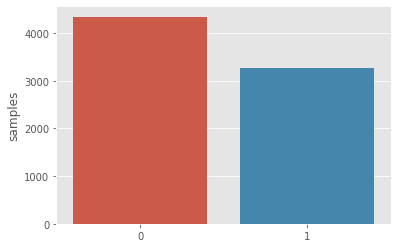

In [72]:
# Class distributions

x = tweet.target.value_counts()
sns.barplot(x.index,x)
plt.ylabel('samples')

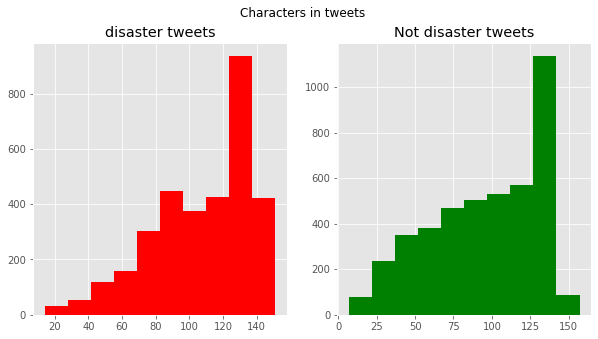

In [73]:
# Number of character in tweet
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

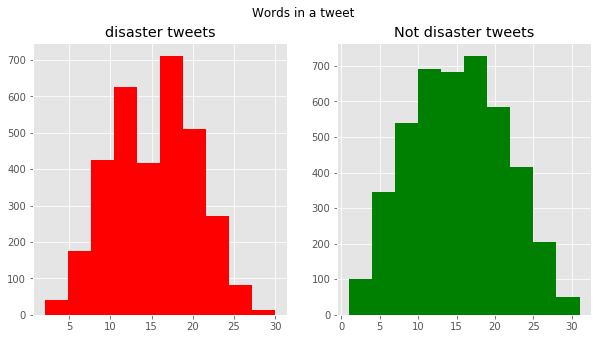

In [74]:
# Number of words in tweet

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=tweet[tweet['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=tweet[tweet['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

In [75]:
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus


In [76]:
# analze stop words in non-disaster tweets

corpus = create_corpus(0)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10]

<BarContainer object of 10 artists>

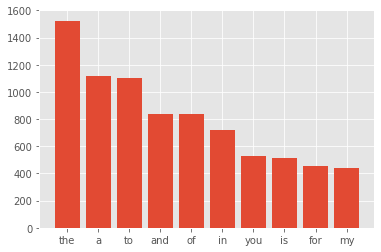

In [77]:
x,y = zip(*top)
plt.bar(x,y)

In [78]:
# analze stop words in disaster tweets

corpus = create_corpus(1)

dic = defaultdict(int)

for word in corpus:
    if word in stop:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10]

<BarContainer object of 10 artists>

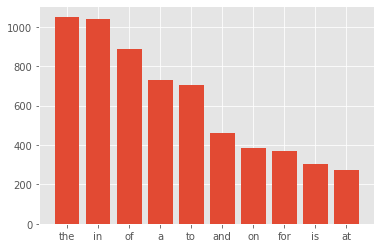

In [79]:
x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

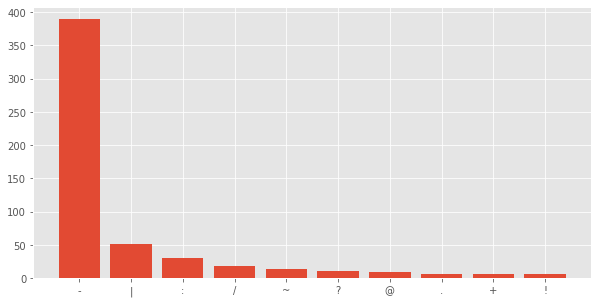

In [80]:
# Analyzing punctuations in disaster tweets

plt.figure(figsize = (10,5))

corpus = create_corpus(1)

dic = defaultdict(int)

punctuation = string.punctuation

for word in corpus:
    if word in punctuation:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10]

x,y = zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

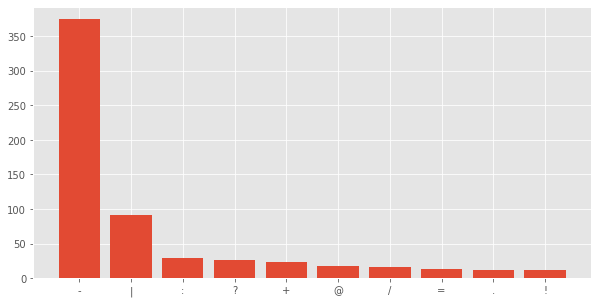

In [81]:
# Analyzing punctuations in non-disaster tweets

plt.figure(figsize = (10,5))

corpus = create_corpus(0)

dic = defaultdict(int)

punctuation = string.punctuation

for word in corpus:
    if word in punctuation:
        dic[word] += 1

top = sorted(dic.items(), key=lambda x:x[1], reverse=True)[:10]

x,y = zip(*top)
plt.bar(x,y)

## Data Cleaning

In [82]:
#Combining both data sets

df = pd.concat([tweet,test])
print(df.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


(10876, 5)


In [83]:
# Removing URLs

example="New competition launched :https://www.kaggle.com/c/nlp-getting-started"

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

remove_URL(example)

'New competition launched :'

In [84]:
df['text'] = df['text'].apply(lambda x:remove_URL(x))

In [85]:
print(df.head())

   id keyword location  target  \
0   1     NaN      NaN     1.0   
1   4     NaN      NaN     1.0   
2   5     NaN      NaN     1.0   
3   6     NaN      NaN     1.0   
4   7     NaN      NaN     1.0   

                                                text  
0  Our Deeds are the Reason of this #earthquake M...  
1             Forest fire near La Ronge Sask. Canada  
2  All residents asked to 'shelter in place' are ...  
3  13,000 people receive #wildfires evacuation or...  
4  Just got sent this photo from Ruby #Alaska as ...  


In [86]:
# Remove HTML Tags
example = """<div> 
<h1>Real or Fake</h1>
<p>Kaggle </p>
<a href="https://www.kaggle.com/c/nlp-getting-started">getting started</a>
</div>"""

def remove_HTMLTags(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'',text)

remove_HTMLTags(example)

' \nReal or Fake\nKaggle \ngetting started\n'

In [87]:
df['text'] = df['text'].apply(lambda x:remove_HTMLTags(x))

In [88]:
# Remove Emojis

# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

remove_emoji("Omg another Earthquake 😔😔")

'Omg another Earthquake '

In [89]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

In [90]:
# Remove punctuations

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

example="I am a #king"
print(remove_punct(example))

I am a king


In [91]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

In [92]:
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spelling(text):
    corrected_text = []
    mispelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in mispelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

text = "corect me plese"
correct_spelling(text)
    

'correct me please'

In [93]:
print(df.head())

   id keyword location  target  \
0   1     NaN      NaN     1.0   
1   4     NaN      NaN     1.0   
2   5     NaN      NaN     1.0   
3   6     NaN      NaN     1.0   
4   7     NaN      NaN     1.0   

                                                text  
0  Our Deeds are the Reason of this earthquake Ma...  
1              Forest fire near La Ronge Sask Canada  
2  All residents asked to shelter in place are be...  
3  13000 people receive wildfires evacuation orde...  
4  Just got sent this photo from Ruby Alaska as s...  


## Glove For Vectorization

In [94]:
# define corpus
from tqdm import tqdm

def create_corpus(df):
    corpus = []
    for tweet in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(tweet) if((word.isalpha() == 1) & (word not in stop))]
        corpus.append(words)
        
    return corpus

In [95]:
corpus = create_corpus(df)

100%|██████████████████████████████████████████████████████████████████████████| 10876/10876 [00:01<00:00, 9129.16it/s]


In [96]:
embedding_dict = {}
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:],'float32')
    embedding_dict[word]=vector
        
f.close()
      



In [97]:
print(embedding_dict['the'])

[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459
  0.8278    0.27062 ]

In [98]:
#Understanding below functions
# https://stackoverflow.com/questions/51956000/what-does-keras-tokenizer-method-exactly-do
# https://stackoverflow.com/questions/42943291/what-does-keras-io-preprocessing-sequence-pad-sequences-do

MAX_LEN = 50
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences = tokenizer_obj.texts_to_sequences(corpus)

tweet_pad = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [99]:
# return a dictionary of name "word_index"
word_index = tokenizer_obj.word_index
print("Number of unique words: ", len(word_index))

Number of unique words:  20342


In [100]:
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))

In [101]:
embedding_matrix.shape

(20343, 100)

In [102]:
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
        
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i] = emb_vec

100%|████████████████████████████████████████████████████████████████████████| 20342/20342 [00:00<00:00, 497771.55it/s]


In [103]:
#Base line model
model=Sequential()

embedding=Embedding(num_words,100,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])

In [104]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 100)           2034300   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,076,605
Trainable params: 42,305
Non-trainable params: 2,034,300
_________________________________________________________________


In [105]:
train = tweet_pad[:tweet.shape[0]]
test = tweet_pad[tweet.shape[0]:]

In [106]:
print(train.shape)
print(test.shape)

(7613, 50)
(3263, 50)


In [108]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(train,tweet['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)


In [109]:
history=model.fit(X_train,y_train,batch_size=4,epochs=15,validation_data=(X_test,y_test),verbose=2)

Train on 6471 samples, validate on 1142 samples
Epoch 1/15
 - 29s - loss: 0.6911 - accuracy: 0.5709 - val_loss: 0.6888 - val_accuracy: 0.5613
Epoch 2/15
 - 28s - loss: 0.6465 - accuracy: 0.6297 - val_loss: 0.5549 - val_accuracy: 0.7644
Epoch 3/15
 - 29s - loss: 0.5783 - accuracy: 0.7289 - val_loss: 0.5188 - val_accuracy: 0.7776
Epoch 4/15
 - 35s - loss: 0.5639 - accuracy: 0.7371 - val_loss: 0.5060 - val_accuracy: 0.7785
Epoch 5/15
 - 41s - loss: 0.5545 - accuracy: 0.7469 - val_loss: 0.5015 - val_accuracy: 0.7837
Epoch 6/15
 - 48s - loss: 0.5500 - accuracy: 0.7509 - val_loss: 0.4962 - val_accuracy: 0.7881
Epoch 7/15
 - 47s - loss: 0.5476 - accuracy: 0.7493 - val_loss: 0.4919 - val_accuracy: 0.7863
Epoch 8/15
 - 48s - loss: 0.5398 - accuracy: 0.7563 - val_loss: 0.4933 - val_accuracy: 0.7828
Epoch 9/15
 - 38s - loss: 0.5393 - accuracy: 0.7585 - val_loss: 0.4905 - val_accuracy: 0.7898
Epoch 10/15
 - 35s - loss: 0.5305 - accuracy: 0.7622 - val_loss: 0.4873 - val_accuracy: 0.7916
Epoch 11/15

In [110]:
sample_sub = pd.read_csv('sample_submission.csv')

In [115]:
y_pre = model.predict(test)
y_pre = np.round(y_pre).astype(int).reshape(3263)
sub = pd.DataFrame({'id' : sample_sub['id'].values.tolist(), 'target': y_pre})
sub.to_csv('submission.csv')
sub.head(20)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
